# REINFORCEMENT LEARNING (DQN) TUTORIAL

Ce tutoriel montre comment utiliser `PyTorch` pour entraîner un agent Deep Q Learning (DQN) sur `CartPole-v1` de `Gymnasium`.

**Tâche** : L'agent doit décider entre deux `actions` : déplacer le chariot vers la `gauche` ou vers la `droite` - afin que le poteau qui lui est attaché reste en équilibre. Vous pouvez trouver plus d'informations sur l'environnement et sur d'autres environnements plus difficiles sur le site web de Gymnasium.

![Cartpole](../image-hosting/TP8_intro_RL/cartpole.gif)

Lorsque l'agent observe l'état actuel de l'environnement et choisit une action, l'environnement passe à un nouvel état et renvoie également une `récompense` qui indique les conséquences de l'action. Dans cette tâche, les récompenses sont de `+1` pour chaque pas de temps incrémental, et l'environnement se termine si le poteau tombe trop loin ou si le chariot se déplace de plus de 2,4 unités par rapport au centre. Cela signifie que les scénarios qui se déroulent mieux durent plus longtemps et accumulent une récompense plus importante.

La tâche CartPole est conçue de manière à ce que les entrées pour l'agent soient `4 valeurs réelles` représentant l'`état` de l'environnement (position, vitesse, etc.). Nous prenons ces 4 entrées sans mise à l'échelle et les passons à travers un petit réseau entièrement connecté avec `2 sorties`, une pour chaque action. Le réseau est entraîné à prédire la valeur attendue pour chaque action, en fonction de l'état d'entrée. L'action ayant la valeur attendue la plus élevée est ensuite choisie.

Commençons par importer les packages.

In [1]:
import torch
import matplotlib
import matplotlib.pyplot as plt
import gym
import keyboard
import random

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"device : {device}")

device : cpu


L'environnement nous est donné par `gym` :

In [2]:
env = gym.make("CartPole-v1", render_mode="rgb_array")

Vous pouvez essayer vous même cet environnement. Utilisez les touches directionnelles pour contrôler le cart. Par défault la cart va à gauche.

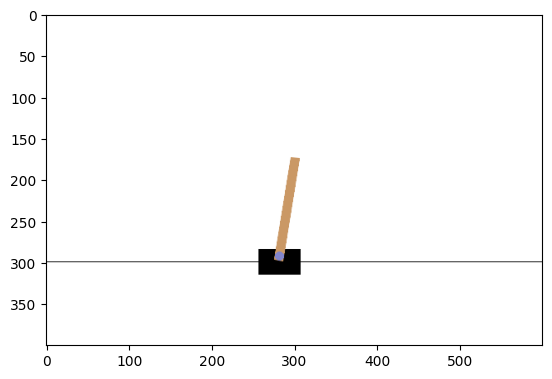

In [5]:
games = 20 # nombre de parties à jouer

env.reset()

action = 0
n = 0

img = plt.imshow(env.render()) # only call this once
while n < games:
   img.set_data(env.render()) # just update the data
   display.display(plt.gcf())
   display.clear_output(wait=True)
   if keyboard.is_pressed('left'):
      action = 0
   elif keyboard.is_pressed('right'):
      action = 1
   observation, reward, terminated, truncated, info = env.step(action)
   if terminated or truncated:
      env.reset()
      action = 0
      n += 1


env.close()

## Replay Memory

**Transition** : Une transition est un tuple `(state, action, next_state, reward)`.

Nous utiliserons une mémoire de relecture d'expérience pour entraîner notre DQN. Elle stocke les transitions que l'agent observe, ce qui nous permet de réutiliser ces données ultérieurement. En les échantillonnant de manière aléatoire, les transitions qui composent un lot sont décorrélées. Il a été démontré que cela stabilise considérablement et améliore la procédure d'entraînement du DQN.

Nous allons créer une `class` pour reprensenter cette mémoire. Cette `class` possede deux méthodes:
- push : ajoute une transition à la mémoire. Une transition est représentée par un dictionnaire : `{state : value, action : value, next_state : value, reward: value}`.
- sample : échantillonne `batch_size` transition. Un échantillon est un dictionnaire de la forme : `{state : list_value, action : list_value, next_state : list_value, reward: list_value}`

Pour implémenter `sample` utiliser les fonctions `zip` et `random.sample`.

In [ ]:
class ReplayMemory():

    def __init__(self, capacity):
        self.memory = []
        self.capacity = capacity

    def push(self, state, action, next_state, reward):
        """Save a transition"""
        pass

    def sample(self, batch_size):
        """Sample a batch of transitions"""
        pass

    def __len__(self):
        return len(self.memory)

# Algorithme DQN

Notre environnement est déterministe, donc toutes les équations présentées ici sont également formulées de manière déterministe pour simplifier les choses. Dans la littérature sur l'apprentissage par renforcement, elles contiendraient également des attentes sur les transitions stochastiques dans l'environnement.

Notre objectif sera de former une politique qui tente de maximiser la récompense cumulative actualisée, $R_{t_0} = \sum_{t=t_0}^\infty \gamma^{t - t_0} r_t$, où $R_{t_0}$ est également connu sous le nom de rendement. La réduction, $\gamma$, doit être une constante entre $0$ et $1$ pour assurer que la somme converge. Une valeur plus faible de $\gamma$ rend les récompenses du futur incertain moins importantes pour notre agent que celles du futur proche dont il peut être assez confiant. Cela encourage également les agents à collecter des récompenses plus proches dans le temps que des récompenses équivalentes qui sont temporellement éloignées dans le futur.

L'idée principale derrière le $Q$-learning est que si nous avions une fonction $Q^* : \text{État} \times \text{Action} \rightarrow \mathbb{R}$ qui pourrait nous dire quelle serait notre récompense si nous prenions une action dans un état donné, alors nous pourrions facilement construire une politique qui maximise nos récompenses :

$\pi^*(s) = \arg\max_a Q^*(s, a)$

Cependant, nous ne savons pas tout sur le monde, donc nous n'avons pas accès à $Q^*$. Mais, puisque les réseaux neuronaux sont des approximateurs de fonctions universels, nous pouvons simplement en créer un et le former pour ressembler à $Q^*$.

Pour notre règle de mise à jour de formation, nous utiliserons le fait que chaque fonction $Q$ pour une certaine politique obéit à l'équation de Bellman :

$Q^\pi(s, a) = r + \gamma Q^\pi(s', \pi(s'))$

La différence entre les deux côtés de l'égalité est connue sous le nom d'erreur de différence temporelle, $\delta$ :

$\delta = Q(s, a) - \left(r + \gamma \max_{a'} Q(s', a')\right)$

Pour minimiser cette erreur, nous utiliserons la perte de Huber. La perte de Huber se comporte comme l'erreur quadratique moyenne lorsque l'erreur est petite, mais comme l'erreur absolue moyenne lorsque l'erreur est grande - cela la rend plus robuste aux valeurs aberrantes lorsque les estimations de $Q$ sont très bruitées. Nous calculons cela sur un lot de transitions, $\mathcal{B}$, échantillonné depuis la mémoire de répétition :

$L = \frac{1}{|\mathcal{B}|} \sum_{(s, a, s', r) \in \mathcal{B}} \mathcal{L}(\delta)$

où

$\mathcal{L}(\delta) = 
\begin{cases} 
\frac{1}{2} \delta^2 & \text{pour } |\delta| \leq 1, \\
| \delta | - \frac{1}{2} & \text{sinon}.
\end{cases}$

Commençons par définir notre modèle. Notre modèle à pour but d'approximer la fonction $Q$. Le nombre d'entrées est donc égale au nombre d'observation et le nombre de sorties est égale au nombre d'action. Avec ce formalisme, si `dqn` est notre réseau de neuronnes et `state` l'état de l'environnement alors :
- `dqn(state)` est un `tensor` contenant les `Q-values` de chacune des deux actions.
- `argmax dqn(state)` est l'action qui doit être choisie.

In [8]:
n_observations = len(env.reset()[0])
n_actions = env.action_space.n

print(f"nombre d'observations : {n_observations}")
print(f"nombre d'actions : {n_actions}")

nombre d'observations : 4
nombre d'actions : 2


In [ ]:
class DQN(torch.nn.Module):
    
    def __init__(self):
        torch.nn.Module.__init__(self)
    
    def forward(self, x):
        return x

Voici deux notions importantes à comprendre avant de continuer ce tp.

**Epsilon-Greedy :**

L'epsilon-greedy est une stratégie d'exploration utilisée dans l'apprentissage par renforcement. Elle permet à un agent de choisir entre explorer de nouvelles actions (exploration) et choisir l'action qui semble actuellement la meilleure en fonction de ses connaissances actuelles (exploitation). 

- Lorsque l'agent utilise l'exploration, il sélectionne une action au hasard avec une probabilité epsilon (ε). Cela permet à l'agent de découvrir de nouvelles actions et de collecter des informations sur leur efficacité.
- Lorsque l'agent utilise l'exploitation, il choisit l'action qui a la meilleure estimation de valeur en fonction de ses connaissances actuelles.

L'idée derrière l'epsilon-greedy est de trouver un équilibre entre l'exploration et l'exploitation. Pendant l'apprentissage initial, l'exploration est favorisée (ε est élevé) pour découvrir rapidement des stratégies potentiellement meilleures. Au fil du temps, l'exploitation devient plus prédominante (ε diminue) à mesure que l'agent acquiert une connaissance plus solide de l'environnement.

**Target Net :**

Le "target net" (ou réseau cible) est un composant essentiel dans les algorithmes d'apprentissage profond par renforcement, tels que DQN (Deep Q-Network). Il est utilisé pour stabiliser et améliorer l'apprentissage de l'agent.

Dans un DQN, il existe deux réseaux de neurones principaux : le "policy net" (ou réseau de politique) et le "target net." Le réseau de politique est utilisé pour estimer la meilleure action à prendre dans un état donné. Le réseau cible, quant à lui, est utilisé pour estimer la valeur future des états.

Le réseau cible est mis à jour moins fréquemment que le réseau de politique. Cette mise à jour lente permet de stabiliser l'apprentissage en évitant les oscillations potentielles des valeurs Q (fonction d'évaluation) lors de la mise à jour fréquente du réseau de politique.

En pratique, le réseau cible est généralement mis à jour périodiquement en copiant les poids du réseau de politique vers le réseau cible. Cela permet de maintenir une estimation plus stable des valeurs Q à long terme, ce qui améliore la convergence de l'algorithme d'apprentissage par renforcement.

Nous définissons ici les hyperparamètres :

In [ ]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = torch.optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

Compléter la fonction `select_action` pour qu'elle renvoie l'action choisie par votre `model` dans l'état `state`. Voici un exemple d'implémentation possible :
- Si `argmax dqn(state) == 0`, aller à gauche.
- Si `argmax dqn(state) == 1`, aller à droite.

N'oubliez pas d'implémenter l'algorithme `epsilon-greedy` en choisissant une action au hasard avec une probabilité de $\varepsilon_{end} + (\varepsilon_{start} - \varepsilon_{end}) * e ^ {-\varepsilon_{decay} \cdot step}$.

In [ ]:
step = 0

def select_action(state):
    pass

Nous allons maitenant coder la boucle d'entrainement de nôtre modèle. La partie compliquée est le calcule de la `loss`

$\delta = Q(s, a) - \left(r + \gamma \max_{a'} Q(s', a')\right)$

In [ ]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)